# Playground of Diffusers

In [1]:
from omegaconf import OmegaConf
import torch
import numpy as np
from typing import Union,Dict,Optional

In [2]:
config = OmegaConf.load("config.yaml")
for key, value in config.items():
    print(key, value)


local_dir ./cached
weights_dtype fp16
proxies {'https': 'https://hf-mirror.com/'}
dataset {'CelebA': 'E:\\AIGC\\VDM\\dataset'}


In [ ]:
# from huggingface_hub import hf_hub_download  
# hf_hub_download(
    # repo_id=config.repo_id,
    # local_dir=config.local_dir,
    # filename=""    
# )

In [ ]:
# Load VAE
from diffusers import AutoencoderKL 
device = torch.device("cuda")
dtype = torch.float16 if config.weights_dtype == "fp16" else torch.float32
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path = r"./cached\models--runwayml--stable-diffusion-v1-5\snapshots\1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9\vae",
    # cache_dir="./cached",
    # proxies=config.proxies
).to(device,dtype)
vae.requires_grad_(False)
for key,value in vae.config.items():
    print(key, value)

VAE is in eval mode while grad is on.

Why scale `0.18215`? 
1. `0.18215` is `1/std` where std is the sqrt of variance of all latent `z`.
2. Mainly to fit all `z` into UNet because different `encoder` has different std.
3. https://github.com/huggingface/diffusers/issues/437

*notice that the last layer of vae encoder does not has a down sampling block*

*So the scale factor is 2 ** (len(block_out_channels) - 1)* 

In [ ]:
# vae in eval mode while grad is on
# 0.18215 ? 
print(vae.training)
x = torch.randn(4,3,512,512).to(device,dtype)
z = vae.encode(x,return_dict=True).latent_dist.sample().mul_(0.18215)
print(z.shape)
y = vae.decode(z / 0.18215).sample
print(torch.nn.functional.mse_loss(x,y,reduction="none").shape)

In [ ]:
import matplotlib.pyplot as plt
def show_image(x:Union[torch.Tensor,np.ndarray]):
    if isinstance(x,torch.Tensor):
        x = x.cpu().detach().numpy()
    plt.imshow(x.transpose(1,2,0))
    plt.show() 

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor,Normalize
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
transform = Compose([Resize((512,512)),ToTensor(),Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])
transform_uncond = Compose([
    Resize((512,512)),
    ToTensor(),
    ])
batch_size = 4

dataset = ImageFolder(root=config.dataset.CelebA,transform=transform_uncond)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
x,_ = next(iter(dataloader))
show_image(make_grid(x))

In [ ]:
x = x.to(device,dtype)
with torch.no_grad():
    z = vae.encode(x).latent_dist.sample().mul_(0.18215)
    print(z.mean(),z.std())
    y = vae.decode(z / 0.18215).sample
    show_image(make_grid(y.to(torch.float32)))

## Try some other models
1. UNet 
   1. Embeddings 
   2. Forwarding
2. CLIP
   1. CLIPImageProcessor
   2. CLIPVisionModelWithProjection

In [ ]:
from diffusers import UNet2DConditionModel
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path=r"./cached\models--runwayml--stable-diffusion-v1-5\snapshots\1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9\unet",
).to(device,dtype)
unet.requires_grad_(False)
for k,v in unet.config.items():
    if k.endswith("type"):
        print(k,v)

__CLIP__

1. Vision
   1. CLIPImageProcessor
   2. CLIPVisionModel
      1. WithProjection
2. Text
   1. CLIPTokenizer
   2. CLIPTextModel
      1. WithProjection


In [ ]:
from transformers import CLIPVisionModelWithProjection
from transformers import CLIPImageProcessor
from PIL import Image
image_processer = CLIPImageProcessor()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    pretrained_model_name_or_path=config.image_encoder_path,
).to(device,dtype)
image_encoder.requires_grad_(False)
z = image_processer(x,
                    return_tensors="pt").pixel_values
print(f"z.shape = {list(z.shape)}")
z = z.to(device,dtype)
enc = image_encoder(z,return_dict=True)
print(enc.image_embeds.shape)


In [ ]:
from transformers import (
        CLIPConfig,
        CLIPTokenizer,
        CLIPTextModel
)
tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5",
        subfolder="tokenizer",
        cache_dir="./cached"
)
cliptextmodel = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5",
        subfolder="text_encoder",
        cache_dir="./cached"        
).to(device,dtype)

In [ ]:
token = tokenizer(["a photo of a cat",
                   "a picture of a man"],
                  return_tensors="pt")
print(token.input_ids.shape)
text_emb = cliptextmodel(token.input_ids.to(device),token.attention_mask.to(device),return_dict=True)
print(text_emb[0].shape)

__Scheduler__
1. DDPM
2. DDIM
3. PNDM
4. ...

__Key parameters__:
1. num_train_timesteps : default to 1000
2. beta 
   1. beta_start
   2. beta_end
   3. beta_schedule
3. steps: use `set_timesteps` method

__Pipeline__ 
1. Backbone Neural Network: UNet or Transformer based model
2. VAE: encoder(train) and decoder(inference)
3. encode_hidden_state: Text Emb or Image Emb, implemented by cross-attention.
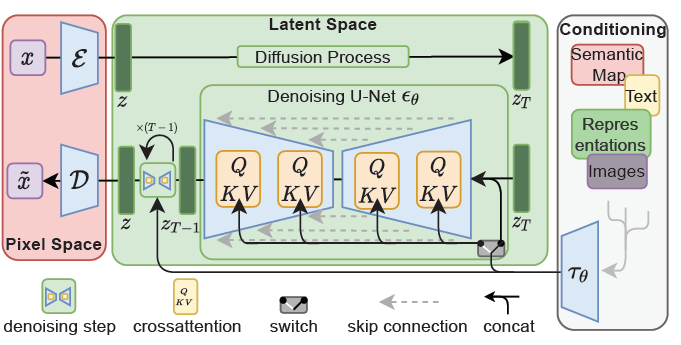

In [ ]:
from diffusers.schedulers import (
    DDIMScheduler,
    PNDMScheduler,
)
from tqdm.auto import tqdm   
import time
scheduler = PNDMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.0120,
    beta_schedule="scaled_linear",
    set_alpha_to_one=True
)
scheduler.init_noise_sigma
ddim_steps = 25
latent_channel = vae.config.latent_channels
sample_size = 64
scheduler.set_timesteps(ddim_steps,device=device)
prompt = ["dog"]
batch_size = len(prompt)
generator = torch.manual_seed(int(time.time()))
with torch.no_grad():
    tokens = tokenizer(prompt,
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")
    maxlen = tokens.input_ids.shape[-1]

    text_emb = cliptextmodel(tokens.input_ids.to(device),return_dict=True)[0]
    uncond_tokens = tokenizer([""]*batch_size,
                              padding="max_length",
                              max_length=maxlen,
                              return_tensors="pt")
    uncond_text_emb = cliptextmodel(uncond_tokens.input_ids.to(device),return_dict=True)[0]
    text_emb = torch.cat([uncond_text_emb,text_emb])
print(text_emb.shape)
z_t = torch.randn((1,
                   latent_channel,
                   sample_size,
                   sample_size),
                  generator=generator).to(device,dtype) * scheduler.init_noise_sigma
w = 3.0 # weight of text embedding
with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        z_t_input = torch.cat([z_t] * 2)
        z_t_input = scheduler.scale_model_input(z_t_input,t)
        predict_noise = unet(z_t_input,t,text_emb).sample
        noise_uncond,noise_cond = torch.chunk(predict_noise,2)
        noise_pred = noise_uncond + w * (noise_cond  - noise_uncond)
        z_t = scheduler.step(noise_pred,t,z_t).prev_sample
        img = vae.decode(z_t / 0.18215).sample
        print(img.shape)
        show_image(make_grid(img.to(torch.float32) / 2 + 0.5).clamp(0,1))
 

__Convert to Pipeline__



In [ ]:
from diffusers.image_processor import VaeImageProcessor
from diffusers import DiffusionPipeline
class LDM(DiffusionPipeline):
    def __init__(
        self,
        vae:AutoencoderKL,
        unet:UNet2DConditionModel,
        text_encoder:CLIPTextModel,
        text_tokenizer:CLIPTokenizer,
        scheduler:Union[DDIMScheduler,PNDMScheduler],
    )->None:
        super().__init__()
        self.register_modules(
            vae=vae,
            unet=unet,
            text_encoder=text_encoder,
            text_tokenizer=text_tokenizer,
            scheduler=scheduler
        )
    def __call__(
        self,
        prompt:Union[str,list[str]],
        steps: int = 25,
        sample_size:int = 64,
        w:float = 1.0,
        generator:Optional[torch.Generator] = None,
    ):
        if isinstance(prompt,str):
            prompt = [prompt]
        batch_size = len(prompt)
        use_cfg = w > 1.0
        device = self._execution_device
        latent_channel = self.vae.config.latent_channels
        vae_processor = VaeImageProcessor()
        with torch.no_grad():
            tokens = self.text_tokenizer(prompt,
                                         padding="max_length",
                                         max_length=self.text_tokenizer.model_max_length,
                                         truncation=True,
                                         return_tensors="pt")
            maxlen = tokens.input_ids.shape[-1]
            text_emb = self.text_encoder(tokens.input_ids.to(device),return_dict=True)[0]
            if use_cfg:
                uncond_tokens = self.text_tokenizer([""]*batch_size,
                                                   padding="max_length",
                                                   max_length=maxlen,
                                                   return_tensors="pt")
                uncond_text_emb = self.text_encoder(uncond_tokens.input_ids.to(device),return_dict=True)[0]
                text_emb = torch.cat([uncond_text_emb,text_emb])
        
        latent = torch.randn((batch_size,
                              latent_channel,
                              sample_size,
                              sample_size),
                             generator=generator).to(device,dtype) * self.scheduler.init_noise_sigma
        self.scheduler.set_timesteps(steps,device=device)
        with torch.no_grad():
            for t in tqdm(self.scheduler.timesteps):
                if use_cfg:
                    latent_input = torch.cat([latent] * 2)
                    latent_input = self.scheduler.scale_model_input(latent_input,t)
                    predict_noise = self.unet(latent_input,t,text_emb).sample
                    noise_uncond,noise_cond = torch.chunk(predict_noise,2)
                    noise_pred = noise_uncond + w * (noise_cond - noise_uncond)
                else :
                    latent_input = self.scheduler.scale_model_input(latent,t)
                    noise_pred = self.unet(latent_input,t,text_emb).sample
                latent = self.scheduler.step(noise_pred,t,latent).prev_sample
        latent = self.vae.decode(latent / 0.18215).sample.to(dtype=torch.float32).clamp(-1,1).cpu().detach()
        image = vae_processor.postprocess(
            latent,
            do_denormalize=[True] * batch_size, 
        )
        return image

In [ ]:
scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.0120,
    beta_schedule="scaled_linear",
    set_alpha_to_one=True
)
ldm = LDM(vae,unet,cliptextmodel,tokenizer,scheduler)
images = ldm("dog",steps=25,w=3.0)

In [ ]:
plt.imshow(images[0])

__How to connect two modules?__  *i.e. ReferenceNet calculate the guidence and then pass it to DenosingNet*

1. Overload the `forward` method of the original module in the `reader` and `writer` in `ReferenceAttnControl` class.
```python
if isinstance(module, BasicTransformerBlock):
    module.forward = hacked_basic_transformer_inner_forward.__get__(
        module, BasicTransformerBlock
    )
if isinstance(module, TemporalBasicTransformerBlock):
    module.forward = hacked_basic_transformer_inner_forward.__get__(
        module, TemporalBasicTransformerBlock
    )

```
2. create two `banks` of `forward` result for RefNet and DenosingNet.
```python
    module.bank = []
                module.attn_weight = float(i) / float(len(attn_modules))
```
3. Once RefNet finish forwarding, the result will then be saved in the `bank`. Sequentially call `update` of the `ReferenceAttnControl`, which move the corresponding result stored in `RefNet`'s `bank` to `DenosingNet`'s `bank`.
```python
for r, w in zip(reader_attn_modules, writer_attn_modules):
                r.bank = [v.clone().to(dtype) for v in w.bank]
```
4. The overloaded forward of `DenosingNet` then use the its bank to fusion.

*一点吐槽：nmd为什么不新写一个module而要用这种方式重载啊啊啊啊啊啊，真不考虑可读性啊😫*

In [ ]:
class MyModule():
    def __init__(self):
        self.var = 1
    def forward(self):
        print(self.forward)
class TryGet():
    def __init__(self,module):
        self.x = 1
        self.net = module
    def hack(self):
        def hacked_forward(self):
            print(self.var)
            self.var = 2
            print(f"after hack {self.var}")
        self.net.forward = hacked_forward.__get__(self.net,MyModule) 
net = MyModule()
get = TryGet(net)
get.hack()
net.forward()

__inference__

Key Parts(input):
1. noise: $\mathcal{N}(0,1)$
2. pose_guidence(single image or squence): pass to pose guider -> obtain `pose_fea` 
3. ref_image
   1. pass to vae_image_processor and vae_encoder to obtain ref_image_latent
   2. pass to clip_image_processor and clip_vision_model_with_projection to obtain `image_prompt_embed`
```python
        # pre-process
        sample = self.conv_in(sample)
        if pose_cond_fea is not None:
            sample = sample + pose_cond_fea
```
Inside Neural Networks:
1. pose_guidence and noise are simply added inside the DenosingNet*
2. `image_prompt_embed` is embeded through cross-attention
3. run RefNet only once if the task is pose2img. However, if the task is to generate long video ...TODO

Output:
1. image or short video or long video(depend on the task)

__Train Stage1__

Key Parts(input):
1. noise: $\mathcal{N}(0,1)$
2. pose_guidence(single image): pass to pose guider -> obtain `pose_fea`
3. ref_image 
   1. pass to vae_encoder to obtain ref_image_latent
   2. pass to clip_vision_model_with_projection to obtain `image_prompt_embed`
4. target_`image`: pass to vae_encoder and then add noise to it to obtain `latent`

Details:
1. pose_guidence, ref_image and target_image are from the same video with pose_guidence and target_image share the same frame index while ref_image is not.
2. All preprocess operations are done inside of `Dataset`, which includes resize,normalization...

Purpose of train_stage_1: train `ReferenceNet` and `DenoisingNet` with pose2image to maintain high quality.

__Train Stage2__

Key Parts(input):
1. noise: $\mathcal{N}(0,1)$
2. pose_guidence(single image): pass to pose guider -> obtain `pose_fea`
3. ref_image 
   1. pass to vae_encoder to obtain ref_image_latent
   2. pass to clip_vision_model_with_projection to obtain `image_prompt_embed`
4. target_`video`: pass to vae_encoder and then add noise to it to obtain `latent`

Details:
1. pose_guidence, ref_image and target_image are from the same video with pose_guidence and target_video share the same frame index while ref_image is randomly selected.
2. All preprocess operations are done inside of `Dataset`, which includes resize,normalization...

Purpose of train_stage_2: train motion module to obtain time consistency.

**Important**

In the train phase, noise is added to either target_image or target_video as a latent input, then pose_image or pose_video is merged by adding them up. 
So, pose_guidence can be viewde as a auxiliary input while most of the information is kept inside the latent variable. 

In the inference phase, latent variable becomes pure noise with no target_image/target_video embeded. But we train the denosing model to `generate video from both noisy target_video and ref_img`, so it won't matter whether latent variable contains target_video or not(it will be noise when timestep = 1000 itself). 